In [11]:
# GMM example
import matplotlib.pyplot as plt
import celluloid
import torch
from IPython.core.display import HTML

In [2]:
N = torch.distributions.MultivariateNormal
def stdN(means, points):
    # means (K, 2); points (B, 2)
    # returns (B, 1)
    I = torch.eye(means.shape[-1])
    return N(means, I[None, :, :]).log_prob(points[:, None, :]).exp() 
    # need to unsqueeze at dim = 1 to allow for broadcast
    # what we get is prob of each point lying in each means' zone
    # => (100, 4)
    # its better to write None than "unsqueeze / squeeze" etc if the case is simple

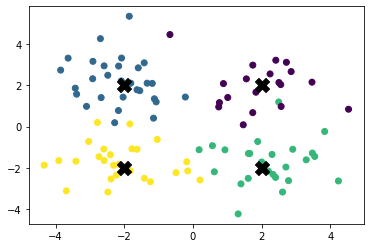

In [3]:
BATCH, DIM, CLASSES = 100, 2, 4
I = torch.eye(DIM) # (2, 2)
# prepare classes -- number from 0..3
y = torch.randint(0, CLASSES, (BATCH,)) 
# fix means for each class
d_means = torch.tensor([[2, 2.], [-2, 2.], [2, -2], [-2, -2.]]) 
# set the prob of each class.. p(k) = 1/K
d_prior = torch.ones(CLASSES) / CLASSES

# sample points
X = N(d_means, I[None, :, :]).sample((BATCH,)) # (100, 4, 2)
X = X[torch.arange(BATCH), y] # (100, 2) retain points that belong to assigned class

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.scatter(d_means[:, 0],  d_means[:, 1], s = 200, marker = "X", color = "black");

In [4]:
stdN(d_means, X).shape # prob of each point lying in each class

torch.Size([100, 4])

In [5]:
def gmm(l_class, means, X):
    # enumerate the total prob of data log p(D ; theta)
    # which is sum_over_all_d (log sum_over_all_class p(d | k) * p(k)) 
    # we do the logs outside.. for now just return 
    # sum_over_all_class p(d | k) * p(k) for each d
    
    # sample a class
    K = l_class * d_prior # (B, 4)
    # log_prob of occurence .. with these means
    return (K * stdN(means, X)).sum(dim = -1) # (B, 4) * (B, 4) .sum(-1) -> (B,)

In [7]:
# what we do not know -- ie latent -- are the classes -- for each datapoint

def latent_var(size):
    return torch.ones(size, requires_grad = True)

l_class = latent_var((X.shape[0], CLASSES))
# run the generative story
print(stdN(d_means, X).sum() / 4) # sum_over_d p(d | k) .. adding a /4 
print(gmm(l_class, d_means, X).sum()) # should be 1/4th of earlier sum... hence a /4

# so.. our story is correct -- the values make sense

tensor(2.0667)
tensor(2.0667, grad_fn=<SumBackward0>)


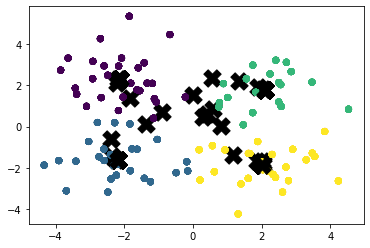

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
camera = celluloid.Camera(fig)

# start with random mu params -- over which we Maximize in EM
mu = torch.rand(CLASSES, DIM) # (4, 2)

for _ in range(20):
    
    # what we do not know -- ie latent -- are the classes -- for each datapoint
    l_class = latent_var((X.shape[0], CLASSES))
    # run the generative story
    gf = gmm(l_class, mu, X) # (B,) p(d)
    gf = gf.log() # (B,) log p(d)
    gf.sum().backward() # sum_over_d log p(d)
    
    # we pull grads all the way upto l_class -- to get
    # d/dk log p(D) for each k --> d/dk p(D) / p(D) --> p(D, class = k) / p(D) --> p(class = k | D)
    
    # E STEP: get latest p(latent | data)
    p_lat = l_class.grad # (B, 4) --- posterior!!
    
    ax.scatter(X[:, 0], X[:, 1], c = p_lat.argmax(dim = 1)) # argmax -- whats the likely class
    ax.scatter(mu[:, 0],  mu[:, 1], s= 300, marker="X", color="black")
    camera.snap()
    
    # M STEP: update mu (theta) such that E_k(log p(data, k)) is maximised
    # this is my problem with differential inference thing
    # you still need to know the M-step formula!
    # i mean you could avoid it with generalized-EM .. forcing a grad descent on mu here
    # but thats just slow i suppose :) 
    # will try that next cell run
    
    # w_ki = p(z = k | d = x_i) -- the matrix elements we have are W_ik
    mu = (p_lat[:, :, None] * X[:, None, :]).sum(dim = 0) / p_lat.sum(dim = 0).view(-1, 1)
    
#     break

In [14]:
# notice the ordering btw -- the order of d_means and mu isn't same
# this leads to a major problem with Mixture Models -- label switching
# say only two classes - p1, p2 -- both equally likely -- and their means u1, u2
# f(x) = p1 * N(x | u1) + p2 * N(x | u2) .. z1 = p1, z2 = p2
# f(x) = p2 * N(x | u2) + p1 * N(x | u1) .. z1 = p2, z2 = p1
# our understanding of z [z1...N] has an ordering ... cool. but no ordering wrt p1, p2

# for many models -- we can't estimate p(z | x) exactly. so we instead sample
# z = [z1, z2] as shown above can occur in two modes with equal probability... 
# it could be [p1, p2] leading to [u1, u2]..or [p2, p1] leading to [u2, u1]
# if you are sampling, and exploring in the same mode... we are good. 
# d_means would be [u1, u2] .. but what you learn and infer could end up being [u2, u1].. doesn't matter much.
# BUT:
# IF YOUR SAMPLER WANDERS FROM ONE MODE TO THE OTHER [it will; samplers are constructed to explore well]
# some samples suggest [p1, p2] .. some suggest [p2, p1]
# so the means you learn.. are all here and there. they don't correspond to [u1, u2] or [u2, u1] ..
# but something in between -- meaningless!

# this is a simpler case.. we dont notice it here.. [why]
print(mu)
print(d_means)

tensor([[-2.1362,  2.3039],
        [-2.1894, -1.6005],
        [ 2.1001,  1.7619],
        [ 2.0146, -1.8731]])
tensor([[ 2.,  2.],
        [-2.,  2.],
        [ 2., -2.],
        [-2., -2.]])


In [15]:
animation = camera.animate(interval=300, repeat_delay=2000)

In [16]:
HTML(animation.to_jshtml())